[View in Colaboratory](https://colab.research.google.com/github/vikasinfrrd/VDCNN-1/blob/master/category_receipt_simplified.ipynb)

In [0]:
import re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Activation
from keras.layers import Embedding, Input, Dense, Dropout, Lambda, MaxPooling1D, Flatten
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authentinon_ receipte and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'19IdA932GOmmKzkyTFX9bn-tFD7kmjNTx' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
title: train123, id: 1OySIpfoO-uPrn1XQsfDKnOBFf7Z3xiTV
downloading to /content/data/train123
title: train_686_raw_text_Category_s3imagepath, id: 1rA5sNgPYz_wybzBIHl38wsrkwilPqdp0
downloading to /content/data/train_686_raw_text_Category_s3imagepath


In [16]:
cd data

[Errno 2] No such file or directory: 'data'
/content/data


In [0]:
train = pd.read_csv('train_686_raw_text_Category_s3imagepath')
train123 = pd.read_csv('train123')

In [18]:
train.head()

,Unnamed: 0,raw_text,Catergory,s3imagepath
0,0,Het Klooster\n Hotel-Brasserie-B&B\nOnderwijsl...,meal,http://s3-us-west-2.amazonaws.com/gimlet-stagi...
1,1,Parking Cantecleer\n Vilvoorde\n\n\n\n\n Binne...,parking,http://s3-us-west-2.amazonaws.com/gimlet-stagi...
2,2,You can win everyweek one\n jood? SamsungGALAX...,meal,http://s3-us-west-2.amazonaws.com/gimlet-stagi...
3,3,my hotel\n CARD SALE VOUCHER\n Table BBC CUSTO...,hotel,http://s3-us-west-2.amazonaws.com/gimlet-stagi...
4,4,KEN ANTWERPEN\n 2000\nTERMINAL:01563106\nPER.:...,miscellaneous,http://s3-us-west-2.amazonaws.com/gimlet-stagi...


In [0]:
train123.columns = train.columns

In [0]:
train_all = pd.concat([train,train123],axis = 0,ignore_index = True)

In [39]:
train_all.tail()

,Unnamed: 0,raw_text,Catergory,s3imagepath
1281,195,DB On...,Airfare,http://s3-eu-central-1.amazonaws.com/gimlet-sc...
1282,196,Online- Ticket ...,Airfare,http://s3-eu-central-1.amazonaws.com/gimlet-sc...
1283,197,DB On...,Airfare,http://s3-eu-central-1.amazonaws.com/gimlet-sc...
1284,198,IDB On...,Airfare,http://s3-eu-central-1.amazonaws.com/gimlet-sc...
1285,199,DB On...,Airfare,http://s3-eu-central-1.amazonaws.com/gimlet-sc...


In [22]:
train_all.shape

(1286, 4)

In [0]:
train_all.to_csv('train_all.csv')

In [13]:
# Create & upload a file.
uploaded = drive.CreateFile({'train_all.csv': 'train_all.csv'})
uploaded.SetContentFile('train_all.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))



Uploaded file with ID 1RBgFY2C0u80VpisaqQqlTv4jwWJZ9_n8


In [0]:
train_all['raw_text'] = train_all['raw_text'].astype('str')

In [0]:
len_raw_text = []
for i in range(train_all.shape[0]):
  len_raw_text.append(len(train_all.raw_text[i]))

In [42]:
train_all.raw_text[i-2:i+2]

1283      DB                                        On...
1284     IDB                                        On...
1285      DB                                        On...
Name: raw_text, dtype: object

In [0]:
#print(train_all.raw_text[1285])

In [0]:
import matplotlib.pyplot as plt

(array([924., 278.,  70.,  13.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   84.,  3446.,  6808., 10170., 13532., 16894., 20256., 23618.,
        26980., 30342., 33704.]),
 <a list of 10 Patch objects>)

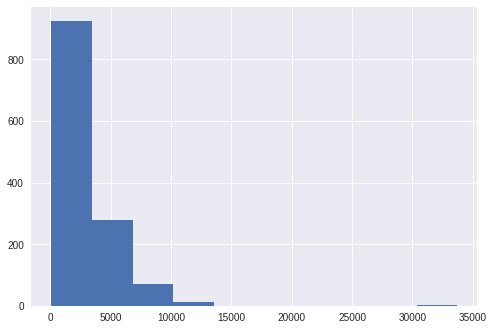

In [45]:
plt.hist(len_raw_text)

In [0]:
raw_text_all = train_all['raw_text'].tolist

In [0]:
#raw_text_all()[:1]

In [0]:
raw_tex_all_one = ' '.join(raw_text_all())

In [49]:
len(raw_tex_all_one)

3034694

In [50]:
len(set(raw_tex_all_one))

470

In [0]:
raw_tex_all_char = set(raw_tex_all_one)

In [0]:
ALPHABET = ''.join(raw_tex_all_char)

In [53]:
train_all.Catergory.value_counts()

meal             288
Grocery          225
taxi             203
Airfare          201
miscellaneous    188
parking           73
fuel              41
transport         39
hotel             28
Name: Catergory, dtype: int64

In [54]:
category_int_encode = dict()
train_all.Catergory_int_enocde = train_all.Catergory
for i,m in enumerate(train_all.Catergory.unique()):
  train_all.Catergory_int_enocde[train_all.Catergory == m] = i
  category_int_encode[str(i)] = m
  print(i)
  print(m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0
meal
1
parking
2
hotel
3
miscellaneous
4
transport
5
Grocery
6
fuel
7
taxi
8
Airfare


In [55]:
train_all.Catergory_int_enocde.value_counts()

0    288
5    225
7    203
8    201
3    188
1     73
6     41
4     39
2     28
Name: Catergory, dtype: int64

In [56]:
category_int_encode

{'0': 'meal',
 '1': 'parking',
 '2': 'hotel',
 '3': 'miscellaneous',
 '4': 'transport',
 '5': 'Grocery',
 '6': 'fuel',
 '7': 'taxi',
 '8': 'Airfare'}

In [0]:
from keras.utils import to_categorical

In [0]:
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [59]:
encoded_data = encode(train_all.Catergory_int_enocde)
print(encoded_data)

Shape of data (BEFORE encode): (1286,)
Shape of data (AFTER  encode): (1286, 9)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [0]:
encoded_data = pd.DataFrame(encoded_data)

In [61]:
encoded_data.describe()

,0,1,2,3,4,5,6,7,8
count,1286.000000,1286.000000,1286.000000,1286.000000,1286.000000,1286.000000,1286.000000,1286.000000,1286.000000
mean,0.223950,0.056765,0.021773,0.146190,0.030327,0.174961,0.031882,0.157854,0.156299
std,0.417051,0.231483,0.145998,0.353434,0.171551,0.380082,0.175754,0.364746,0.363279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
train_all = pd.concat([train_all,encoded_data],axis = 1)

In [63]:
train_all.head()

,Unnamed: 0,raw_text,Catergory,s3imagepath,0,1,2,3,4,5,6,7,8
0,0,Het Klooster\n Hotel-Brasserie-B&B\nOnderwijsl...,0,http://s3-us-west-2.amazonaws.com/gimlet-stagi...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Parking Cantecleer\n Vilvoorde\n\n\n\n\n Binne...,1,http://s3-us-west-2.amazonaws.com/gimlet-stagi...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,You can win everyweek one\n jood? SamsungGALAX...,0,http://s3-us-west-2.amazonaws.com/gimlet-stagi...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,my hotel\n CARD SALE VOUCHER\n Table BBC CUSTO...,2,http://s3-us-west-2.amazonaws.com/gimlet-stagi...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,KEN ANTWERPEN\n 2000\nTERMINAL:01563106\nPER.:...,3,http://s3-us-west-2.amazonaws.com/gimlet-stagi...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
np.random.seed(10)
train_index  = np.random.choice(train_all.shape[0],np.int16(train_all.shape[0] * .98))
test_index = train.index.isin(train_index)

In [65]:
train_all.columns

Index(['Unnamed: 0', 'raw_text', 'Catergory', 's3imagepath', 0, 1, 2, 3, 4, 5,
       6, 7, 8],
      dtype='object')

In [66]:
[1,list(np.arange(5,14))]

[1, [5, 6, 7, 8, 9, 10, 11, 12, 13]]

In [0]:
train = train_all.iloc[train_index,[1,4,5, 6, 7, 8, 9, 10, 11, 12]]
test = train_all.iloc[~test_index,[1,4,5, 6, 7, 8, 9, 10, 11, 12]]

In [68]:
train.shape

(1260, 10)

In [69]:
test.shape

(237, 10)

In [70]:
test.describe()

,0,1,2,3,4,5,6,7,8
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.0,237.000000
mean,0.362869,0.101266,0.033755,0.320675,0.054852,0.046414,0.075949,0.0,0.004219
std,0.481845,0.302319,0.180981,0.467724,0.228174,0.210824,0.265478,0.0,0.064957
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [0]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [0]:
#len(ALPHABET)=68
#ALPHABET = 'abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’"/|_#$%ˆ&*˜‘+=<>()[]{} '
FEATURE_LEN = 1024*6 #maxlen
path = '/content/data/'
TRAIN_DATA_FILE=path+'train.csv'
TEST_DATA_FILE=path+'test.csv'

In [0]:
def get_char_dict():
    char_dict={}
    for i,c in enumerate(ALPHABET):
        char_dict[c]=i+1
    return char_dict

def char2vec(text, max_length=FEATURE_LEN):
    char_dict = get_char_dict()
    data=np.zeros(max_length)
    
    for i in range(0, len(text)):
        if i >= max_length:
            return data
        
        elif text[i] in char_dict:
            data[i] = char_dict[text[i]]
        
        else:
            data[i]=68
    return data
    

def conv_shape(conv):
    return conv.get_shape().as_list()[1:]

replace_ip=re.compile(r'([0-9]+)(?:\.[0-9]+){3}',)
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()
    
    
    
    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    
    
    #Replace IP address
    text=replace_ip.sub('',text)
    
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
train_df = pd.read_csv(TRAIN_DATA_FILE)
test_df = pd.read_csv(TEST_DATA_FILE)

In [0]:
list_sentences_train = train_df["raw_text"].fillna("NA").values

In [76]:
list_sentences_train[:4]

array(['   DB                                       Online-Ticket                    VIETA\r\n\r\n\r\nICE  Fahrkarte                                                                     knicken!\r\n Fahrtantrittam  06.06.2018  oreis  06.05.comICECE2KG                         nicht\r\n                                  moengGoleston\r\n Flexpreis  (EinfacheneFahrtFahrt))    is06Solingen.06.2016    2KKLEINETNO                      bitte\r\n  Klasse:     2   2KL1  Erw.  Numberg      2017SOUMS\r\n          061187GOUMEFlexpreis  06.06.     CEK     E                           Barcode\r\n         .              Erw            Solingen    GOMEN\r\n    W:0           KI1     .        era\r\n Hinfahrt:   Nürnberg   >   Solingen,  mitICE     BEW\r\n  Über:  06   VIA:(AN/FUE)*WUE*(DA*MZ/F)*LM*K*D\r\n Umtausch/Erstattungkostenlos  bis  1  Tagvor  Reiseantritt(Hinfahrt).     SO\r\n\r\n City   mobil\r\n  Gültigkeit:06.06.2018,  Klasse:  2,  Erw.1.2.che  74  PYDIS\r\nEgebiet  Verkehrsverbund  Rhein-Ruhr(

In [0]:
list_classes = ["0","1", "2", "3", "4", "5", "6","7","8"]
y = train_df[list_classes].values

In [78]:
y[:4]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [79]:
train_df.head()

,Unnamed: 0,raw_text,0,1,2,3,4,5,6,7,8
0,1149,DB On...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,527,CLIENTTICKET\n POP UP 1 ANTWERP\n AALST\n Term...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1147,DB O...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1180,DB On...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,733,Alberto Alvarez Ribas\r\n\r\nDe: ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [81]:
train_df.describe()

,Unnamed: 0,0,1,2,3,4,5,6,7,8
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,634.903968,0.253175,0.061111,0.023016,0.145238,0.034921,0.159524,0.028571,0.141270,0.153175
std,368.398937,0.435003,0.239629,0.150013,0.352481,0.183652,0.366309,0.166665,0.348438,0.360299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,313.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,627.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,954.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1285.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
list_sentences_test = test_df["raw_text"].fillna("NA").values

In [0]:
data=[]
for text in list_sentences_train:
    data.append(char2vec(text))
data=np.array(data)

test_data = []
for text in list_sentences_test:
    test_data.append(char2vec(text))
test_data=np.array(test_data)

(array([ 528.,  185.,  385.,  764.,  176.,   75.,  148.,  102., 3171.,
         610.]),
 array([  5. ,  51.4,  97.8, 144.2, 190.6, 237. , 283.4, 329.8, 376.2,
        422.6, 469. ]),
 <a list of 10 Patch objects>)

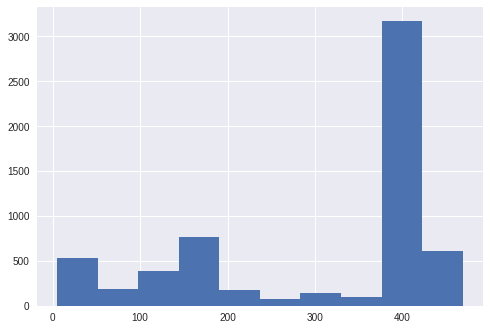

In [85]:
plt.hist(data[0])

In [0]:
def ConvolutionalBlock(input_shape, num_filters):
    model=Sequential()

    #1st conv layer
    model.add(Conv1D(filters = num_filters, kernel_size = 3, strides = 1, padding = "same", input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    #2nd conv layer
    model.add(Conv1D(filters = num_filters, kernel_size = 3, strides = 1, padding = "same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    return model

#https://www.tensorflow.org/api_docs/python/tf/nn/top_k
def top_kmax(x):
    x=tf.transpose(x, [0, 2, 1])
    k_max = tf.nn.top_k(x, k=top_k)
    return tf.reshape(k_max[0], (-1, num_filters[-1]*top_k))

In [0]:
def simple_model(num_filters, num_classes, sequence_max_length, num_chars, embedding_size, top_k, learning_rate=0.001):
    inputs=Input(shape=(sequence_max_length, ), dtype='int32', name='input')
    embedded_seq = Embedding(num_chars, embedding_size, input_length=sequence_max_length)(inputs)
    embedded_seq = BatchNormalization()(embedded_seq)
    #1st Layer
    conv = Conv1D(filters=64, kernel_size=3, strides=2, padding="same")(embedded_seq)

        #ConvBlocks
    #for i in range(len(num_filters)):
    #  conv = ConvolutionalBlock(conv_shape(conv), num_filters[i])(conv)
    #  conv = MaxPooling1D(pool_size=3, strides=2, padding="same")(conv)
    
    conv = Conv1D(filters=64, kernel_size=3, strides=1, padding="valid")(conv)
    conv = Conv1D(filters=64, kernel_size=3, strides=1, padding="valid")(conv)
    conv = Conv1D(filters=64, kernel_size=3, strides=1, padding="valid")(conv)
    conv = Conv1D(filters=64, kernel_size=3, strides=1, padding="valid")(conv)







    conv = Conv1D(filters=64, kernel_size=192, strides=1, padding="valid")(conv)



    # fully connected layers
    # in original paper they didn't used dropouts
    fc1=Dense(512, activation='relu', kernel_initializer='he_normal')(conv)
    fc1=Dropout(0.3)(fc1)
    fc2=Dense(512, activation='relu', kernel_initializer='he_normal')(fc1)
    fc2=Dropout(0.3)(fc2)
    out=Dense(num_classes, activation='softmax')(fc2)
    out=Flatten()(out)
    
    #optimizer
    #sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=False)
    
    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
  

In [111]:
num_filters = [64, 64, 64, 64]
model= simple_model(num_filters=num_filters, num_classes=9,num_chars=470, sequence_max_length=FEATURE_LEN,embedding_size=50,top_k=3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6144)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 6144, 50)          23500     
_________________________________________________________________
batch_normalization_100 (Bat (None, 6144, 50)          200       
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 3072, 64)          9664      
_________________________________________________________________
sequential_45 (Sequential)   (None, 3072, 64)          25216     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 1536, 64)          0         
_________________________________________________________________
sequential_46 (Sequential)   (None, 1536, 128)         75008     
__________

In [0]:
def limit_mem():
    import keras.backend as K
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
    print('gpu memory cleaned')
    
def preds(k):
    from datetime import datetime
    y_temp = np.zeros((len(test_data), len(list_classes)))
    y_pred = np.zeros((len(test_data), len(list_classes)))
    i=0;
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k, random_state=2)

    for train_index, test_index in kf.split(data):
        limit_mem()
        start=datetime.now()
        print('fold====================>>>>>>>>>>',i+1)
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = None
        num_filters = [64, 128, 256, 512]
        model=simple_model(num_filters=num_filters, num_classes=9,num_chars=470, sequence_max_length=FEATURE_LEN,embedding_size=50,top_k=3)

        early_stopping =EarlyStopping(monitor='val_loss', patience=5)
        bst_model_path = 'cv10_best_weights'+str(i+1) + '.h5'
        model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

        hist = model.fit(X_train, y_train, \
                validation_data=(X_test, y_test), \
                epochs=200, batch_size=256,callbacks=[early_stopping, model_checkpoint])

        bst_val_score = min(hist.history['val_loss'])
        print('bst_val_score',bst_val_score)

        model.load_weights(bst_model_path)
        #model.fit(data, y,epochs=2, batch_size=256, shuffle=True,)
        
        y_temp = model.predict([test_data], batch_size=256, verbose=1)
        y_pred+=y_temp
        end=datetime.now()
        print(" ")
        print('time taken for this fold', end-start)
        i+=1
    y_test_pred=y_pred/k
    return y_test_pred

In [0]:
y_test=preds(5)

In [0]:
ls

cv10_best_weights1.h5  test.csv
cv10_best_weights2.h5  train123
cv10_best_weights3.h5  train_686_raw_text_Category_s3imagepath
cv10_best_weights4.h5  train.csv
cv10_best_weights5.h5


In [0]:
from google.colab import files

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'test.csv': 'test.csv'})
uploaded.SetContentFile('test.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Uploaded file with ID 1ni3xXDIR2hOkLLWwILDFNVj0UuC4I2dD


In [0]:
model.load_weights('cv10_best_weights5.h5' , by_name=False)

In [0]:
test_data_result = model.predict(test_data)

In [0]:
test_data_result[:2]

array([[0.61010987, 0.11216   , 0.02600799, 0.227153  , 0.06340238,
        0.03155671, 0.04278218, 0.00870034, 0.00530561],
       [0.6073629 , 0.11009638, 0.02613009, 0.22617193, 0.06281638,
        0.03249059, 0.04217343, 0.00875956, 0.00525018]], dtype=float32)

In [0]:
y_test.shape

(262, 9)

In [0]:
def decode(datum):
    return np.argmax(datum)

In [0]:
test_df.head()

,Unnamed: 0,raw_text,1,2,3,4,5,6,7,8,9
0,1,Parking Cantecleer\n Vilvoorde\n\n\n\n\n Binne...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,ZARA\n\n\n ZARA ANTWERPEN\n MEIR 58\n Tel: 03 ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7,RayCohes liketti\n Noels DarkW\n Lunch Lounge\...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,"Park Passage 44\n Rue de l'Ommegang, 16/20\n B...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,WWW .STADSPARK .BE\nParklaan 56\n2300 Turnhout...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
y_test.shape

(249, 9)

In [0]:
np.argmax(y_test,axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [0]:
sum(np.argmax(np.array(test_df.iloc[:,[2,3,4,5,6,7,8,9,10]]),axis = 1) == np.argmax(y_test,axis = 1))/y_test.shape[0]

0.3654618473895582

In [0]:
np.argmax(np.array(test_df.iloc[:,[2,3,4,5,6,7,8,9,10]]),axis = 1)

array([1, 3, 0, 1, 0, 1, 1, 3, 0, 0, 0, 0, 3, 0, 0, 4, 1, 1, 3, 0, 2, 0,
       3, 3, 4, 3, 3, 0, 3, 3, 3, 1, 5, 0, 3, 0, 0, 3, 0, 0, 5, 3, 3, 0,
       0, 6, 6, 0, 0, 0, 6, 0, 6, 0, 5, 3, 6, 0, 0, 6, 3, 0, 4, 3, 0, 6,
       6, 4, 3, 0, 2, 4, 3, 6, 0, 0, 6, 0, 0, 1, 3, 3, 6, 3, 3, 4, 0, 0,
       3, 0, 0, 2, 0, 0, 0, 3, 3, 6, 3, 3, 3, 3, 3, 0, 0, 1, 3, 0, 1, 0,
       1, 0, 3, 5, 3, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 8, 1, 0, 3, 0, 4,
       4, 2, 3, 1, 3, 3, 3, 3, 1, 5, 3, 3, 3, 3, 0, 0, 0, 0, 2, 3, 3, 0,
       0, 0, 4, 3, 1, 1, 3, 4, 3, 0, 0, 3, 1, 3, 3, 0, 3, 3, 0, 4, 3, 0,
       3, 3, 0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 0, 4, 0, 3, 3, 1, 0, 1, 1, 0,
       5, 1, 3, 1, 1, 2, 4, 1, 3, 0, 0, 0, 6, 0, 5, 4, 2, 6, 3, 0, 0, 3,
       5, 0, 3, 3, 3, 3, 0, 1, 3, 3, 0, 0, 0, 0, 3, 0, 3, 3, 6, 6, 4, 0,
       6, 6, 6, 3, 5, 5, 5])

In [0]:
sum(np.argmax(np.array(test_df.iloc[:,[2,3,4,5,6,7,8,9,10]]),axis = 1) == 1)

25